<a href="https://colab.research.google.com/github/Graur/mipt/blob/master/HW4_Graur_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ДЗ № 4: Продвинутая визуализация данных (Граур Андрей)


In [84]:
!pip install pyod

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from scipy.stats import norm
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score
from pyod.models.hbos import HBOS
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

----------------------------------------------------------

### Задание 1. Сравнение моделей обучения с учителем (4 балла)

Используя разные алгоритмы машинного обучения, проанализируйте наш датасет на наличие выбросов и аномалий. В качестве переменных для анализа используйте только вес и рост.

Создайте поле из 6 графиков. Каждый график (scatter plot) должен иметь заголовок, названия полей, прозрачность точек 0.8. Должны отсутствовать рамки со всех сторон. Пометьте аномалии красным цветом, а все остальные данные — зеленым.

Поместите на графики следующие 6 алгоритмов:

- Interquartile range (IQR) — возьмите выбросы по x и y.
- Isolation forest.
- Local Outlier Factor.
- One-class SVM.
- Gaussian Mixture.
- DBSCAN.


Напишите, какие модели показали себя лучше всего и почему.

In [86]:
weight_height = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/weight-height.csv')
weight_height.head(10)

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
5,Male,67.253016,152.212156
6,Male,68.785081,183.927889
7,Male,68.348516,167.971110
8,Male,67.018950,175.929440
9,Male,63.456494,156.399676


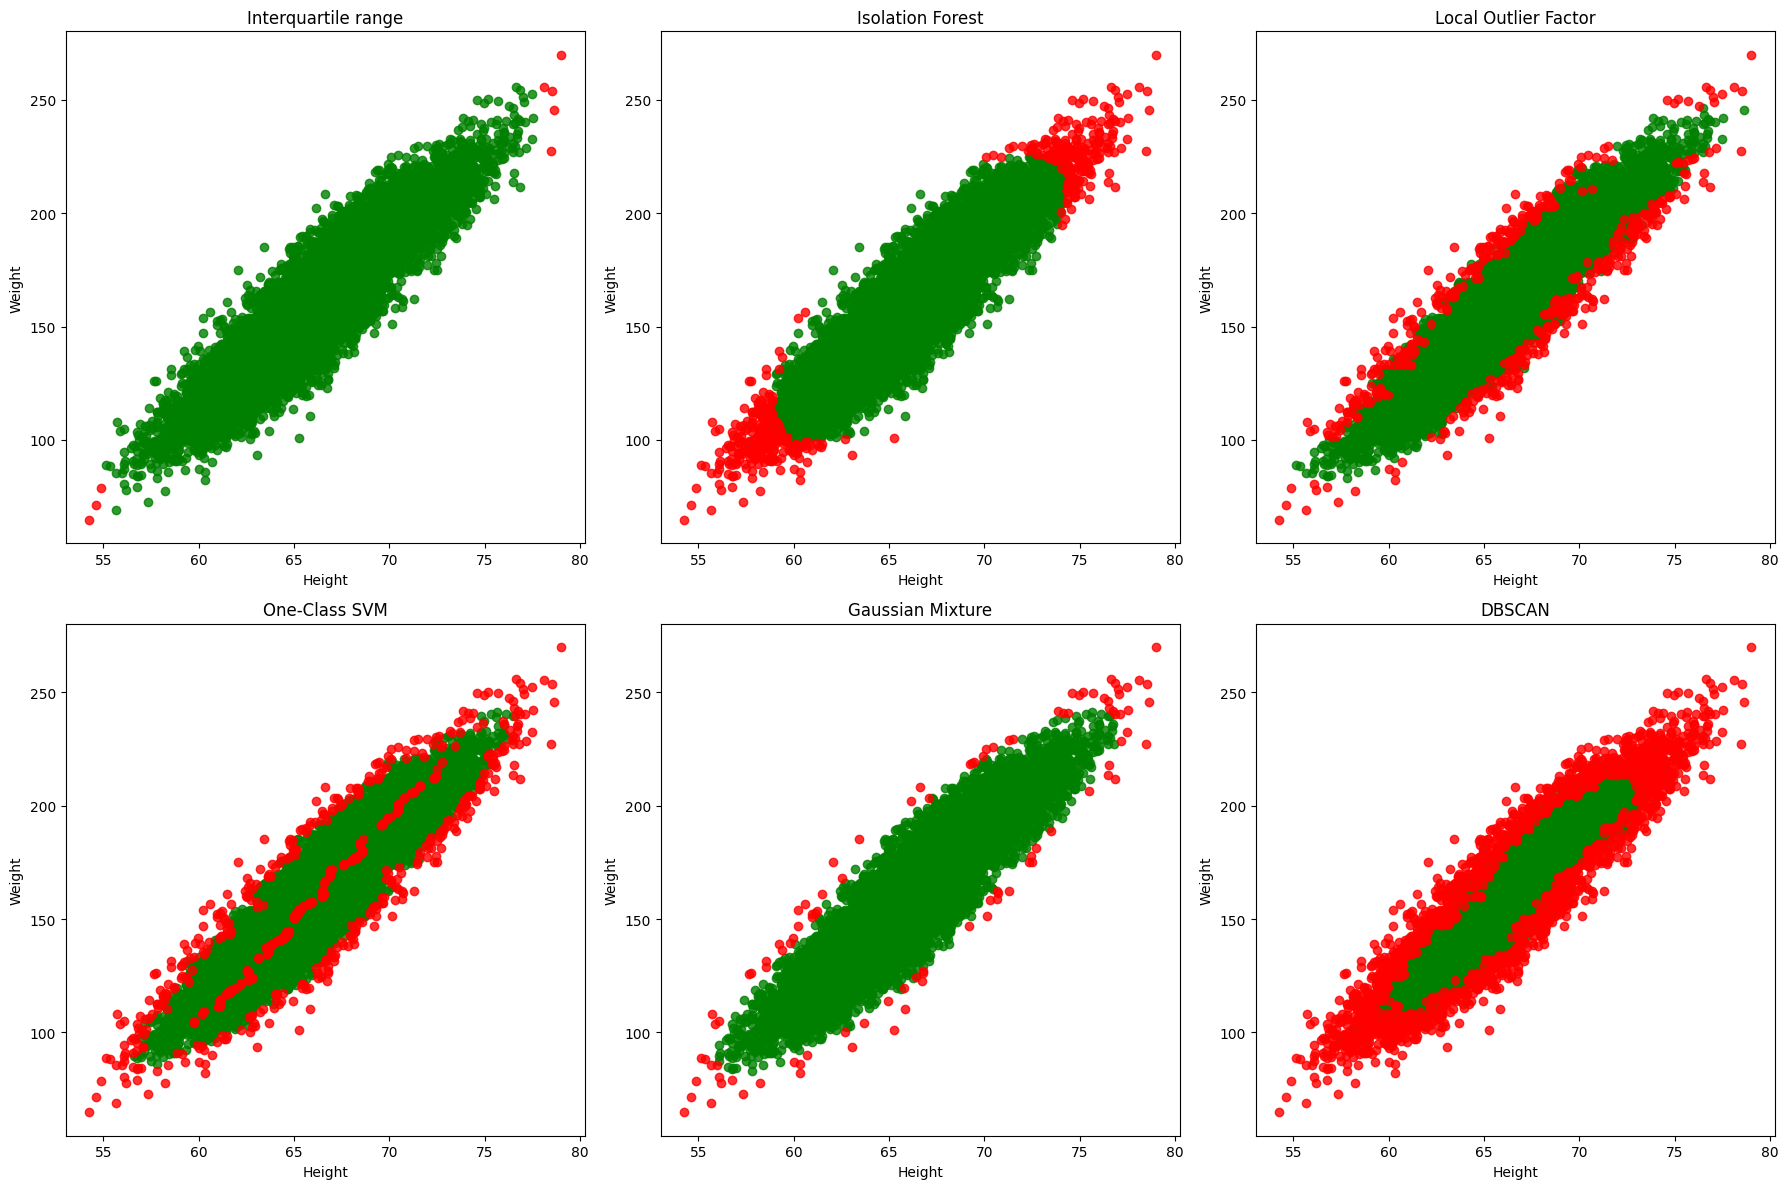

In [87]:

data = weight_height[['Height', 'Weight']]

# Определение алгоритмов
outliers_fraction = 0.05
classifiers = {
    "Interquartile range": lambda x: (x < np.percentile(x, 25) - 1.5 * (np.percentile(x, 75) - np.percentile(x, 25))) | (x > np.percentile(x, 75) + 1.5 * (np.percentile(x, 75) - np.percentile(x, 25))),
    "Isolation Forest": IsolationForest(contamination=outliers_fraction),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, contamination=outliers_fraction),
    "One-Class SVM": OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1),
    "Gaussian Mixture": GaussianMixture(n_components=2, covariance_type='full', max_iter=100, random_state=42),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=10)
}

# Построение графиков
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for ax, (clf_name, clf) in zip(axs.flatten(), classifiers.items()):
    if clf_name == "Interquartile range":
        anomalies = clf(data['Height']) | clf(data['Weight'])
    elif clf_name == "Gaussian Mixture":
        clf.fit(data)
        anomalies = clf.score_samples(data) < -10
    else:
        anomalies = clf.fit_predict(data) == -1

    ax.scatter(data['Height'][~anomalies], data['Weight'][~anomalies], color='green', alpha=0.8)
    ax.scatter(data['Height'][anomalies], data['Weight'][anomalies], color='red', alpha=0.8)
    ax.set_title(clf_name)
    ax.set_xlabel('Height')
    ax.set_ylabel('Weight')
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


### Вывод:
В данной задаче, наилучшие результаты могут быть получены с использованием Isolation Forest и Local Outlier Factor, так как они обычно работают хорошо для данных без явных структур и обладают хорошей производительностью. Но у них так же есть свои преимущества и недостатки:

1) Isolation Forest:

- Преимущества: Эффективен при обнаружении выбросов в больших наборах данных.
Не требует предположений о распределении данных.
- Недостатки: Может недооценивать аномалии в плотных областях данных.

2) Local Outlier Factor (LOF):

- Преимущества: Хорошо работает для обнаружения выбросов в плотных областях данных. Учитывает локальную плотность данных.
- Недостатки: Может давать неправильные результаты в случае, если плотность данных неоднородна.

-------------------------------

### Задание 2. Проверка влияния параметров Isolation Forest на итоговые параметры (3 балла)
После обучения модели выполните следующее:

- Обучите модель Isolation Forest на данных Х с использованием найденных оптимальных параметров (для этого оберните Isolation Forest в sklearn.model_selection.GridSearchCV). В GridSearchCV используйте params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}.
- Сделайте предсказания на данных Х.
- Поиграйте с параметром n_jobs — создайте 6 разных визуализаций с параметрами от 1 до 6.
- Замените значения предсказаний, где 1 соответствует «нормальному» наблюдению (normal), а -1 — «выбросу» (outlier).
- Выведите лучшие параметры модели Isolation Forest для всех 6 параметров (для лучшего понимания оформите выводы).


In [88]:
thyroid = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/annthyroid_unsupervised_anomaly_detection.csv', sep=';').iloc[:, :-2]
thyroid.head()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,o
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,o
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,o
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.0,3.0,24.0,61.0,39.0,o
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,3.0,5.0,116.0,4.0,o


In [89]:
thyroid["Outlier_label "] = thyroid["Outlier_label "].astype("category").cat.codes
thyroid.head()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,1
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,1
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,1
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.0,3.0,24.0,61.0,39.0,1
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,3.0,5.0,116.0,4.0,1


In [90]:
thyroid.describe()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
count,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,...,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000
mean,0.595098,0.307548,0.134615,0.015616,0.013158,0.038317,0.011278,0.014315,0.016773,0.062753,...,0.008531,0.025448,0.000145,0.049740,1.603466,11.772446,94.253834,88.270139,95.257058,0.036148
std,6.189326,0.461512,0.341337,0.123993,0.113959,0.191974,0.105606,0.118793,0.128428,0.242536,...,0.091975,0.157494,0.012025,0.217422,14.047218,11.836250,50.555642,33.909845,55.031137,0.186672
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000500,0.002500,0.050000,0.002400,0.000000
25%,0.370000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000680,0.020100,77.000000,83.000000,81.000000,0.000000
50%,0.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001700,13.000000,101.000000,96.000000,105.000000,0.000000
75%,0.670000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.002700,22.000000,123.000000,104.000000,125.000000,0.000000
max,515.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,494.000000,95.000000,395.000000,233.000000,642.000000,1.000000


In [91]:
thyroid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6916 entries, 0 to 6915
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        6916 non-null   float64
 1   Sex                        6916 non-null   float64
 2   on_thyroxine               6916 non-null   float64
 3   query_on_thyroxine         6916 non-null   float64
 4   on_antithyroid_medication  6916 non-null   float64
 5   sick                       6916 non-null   float64
 6   pregnant                   6916 non-null   float64
 7   thyroid_surgery            6916 non-null   float64
 8   I131_treatment             6916 non-null   float64
 9   query_hypothyroid          6916 non-null   float64
 10  query_hyperthyroid         6916 non-null   float64
 11  lithium                    6916 non-null   float64
 12  goitre                     6916 non-null   float64
 13  tumor                      6916 non-null   float

In [92]:
tmp_labels = thyroid['Outlier_label ']
thyroid = thyroid.drop(['Outlier_label '], axis=1)
thyroid = (thyroid-thyroid.mean())/thyroid.std()
thyroid['Outlier_label '] = tmp_labels

<Axes: >

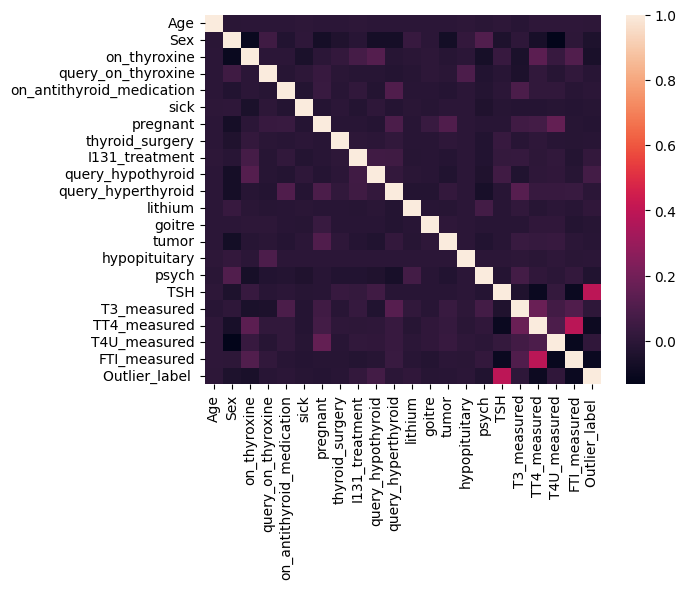

In [93]:
corr = thyroid.corr()
sns.heatmap(corr)

In [94]:
print(corr['Outlier_label '])

Age                         -0.000331
Sex                         -0.043454
on_thyroxine                -0.058223
query_on_thyroxine          -0.011896
on_antithyroid_medication   -0.001968
sick                        -0.014444
pregnant                    -0.020683
thyroid_surgery             -0.010295
I131_treatment               0.016931
query_hypothyroid            0.068073
query_hyperthyroid          -0.001070
lithium                      0.011939
goitre                      -0.017964
tumor                       -0.011619
hypopituitary               -0.002329
psych                       -0.033617
TSH                          0.392347
T3_measured                  0.005928
TT4_measured                -0.096712
T4U_measured                 0.012228
FTI_measured                -0.099859
Outlier_label                1.000000
Name: Outlier_label , dtype: float64


Мы видим, что между столбцами очень мало корреляции: ТТГ имеет наибольшую связь с тем, есть ли у вас заболевание щитовидной железы или нет.

In [95]:
X = thyroid.drop(['Outlier_label '], axis=1)
Y = thyroid['Outlier_label ']

In [96]:
outliers = len(thyroid[thyroid['Outlier_label ']==1])
outlier_fraction = len(thyroid[thyroid['Outlier_label ']==1])/float(len(thyroid[thyroid['Outlier_label ']==0]))

In [97]:
outliers

250

Обучение модели Isolation Forest

In [98]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}
gscv = GridSearchCV(IsolationForest(n_jobs=6, random_state=5, contamination=outlier_fraction), params, scoring='homogeneity_score', cv=5)
gscv.fit(X, Y)
scores_prediction = gscv.decision_function(X)
y1_pred = gscv.predict(X)
y1_pred[y1_pred == 1] = 0
y1_pred[y1_pred == -1] = 1
n_errors = (y1_pred != Y).sum()
print(f'Лучшие параметры: {gscv.best_params_}')

Лучшие параметры: {'max_features': 4, 'n_estimators': 9}


In [99]:
print(f'Лучшие параметры: {gscv.best_params_}')

Лучшие параметры: {'max_features': 4, 'n_estimators': 9}


In [100]:
print("{}: {}".format("Аномальные точки Isolation Forest",n_errors))
print("Precision:",accuracy_score(Y,y1_pred))
print(classification_report(Y,y1_pred))

Аномальные точки Isolation Forest: 326
Precision: 0.9528629265471371
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6666
           1       0.35      0.37      0.36       250

    accuracy                           0.95      6916
   macro avg       0.67      0.67      0.67      6916
weighted avg       0.95      0.95      0.95      6916



n_jobs = 1 Количество выбросов: 260
n_jobs = 2 Количество выбросов: 260
n_jobs = 3 Количество выбросов: 260
n_jobs = 4 Количество выбросов: 260
n_jobs = 5 Количество выбросов: 260
n_jobs = 6 Количество выбросов: 260


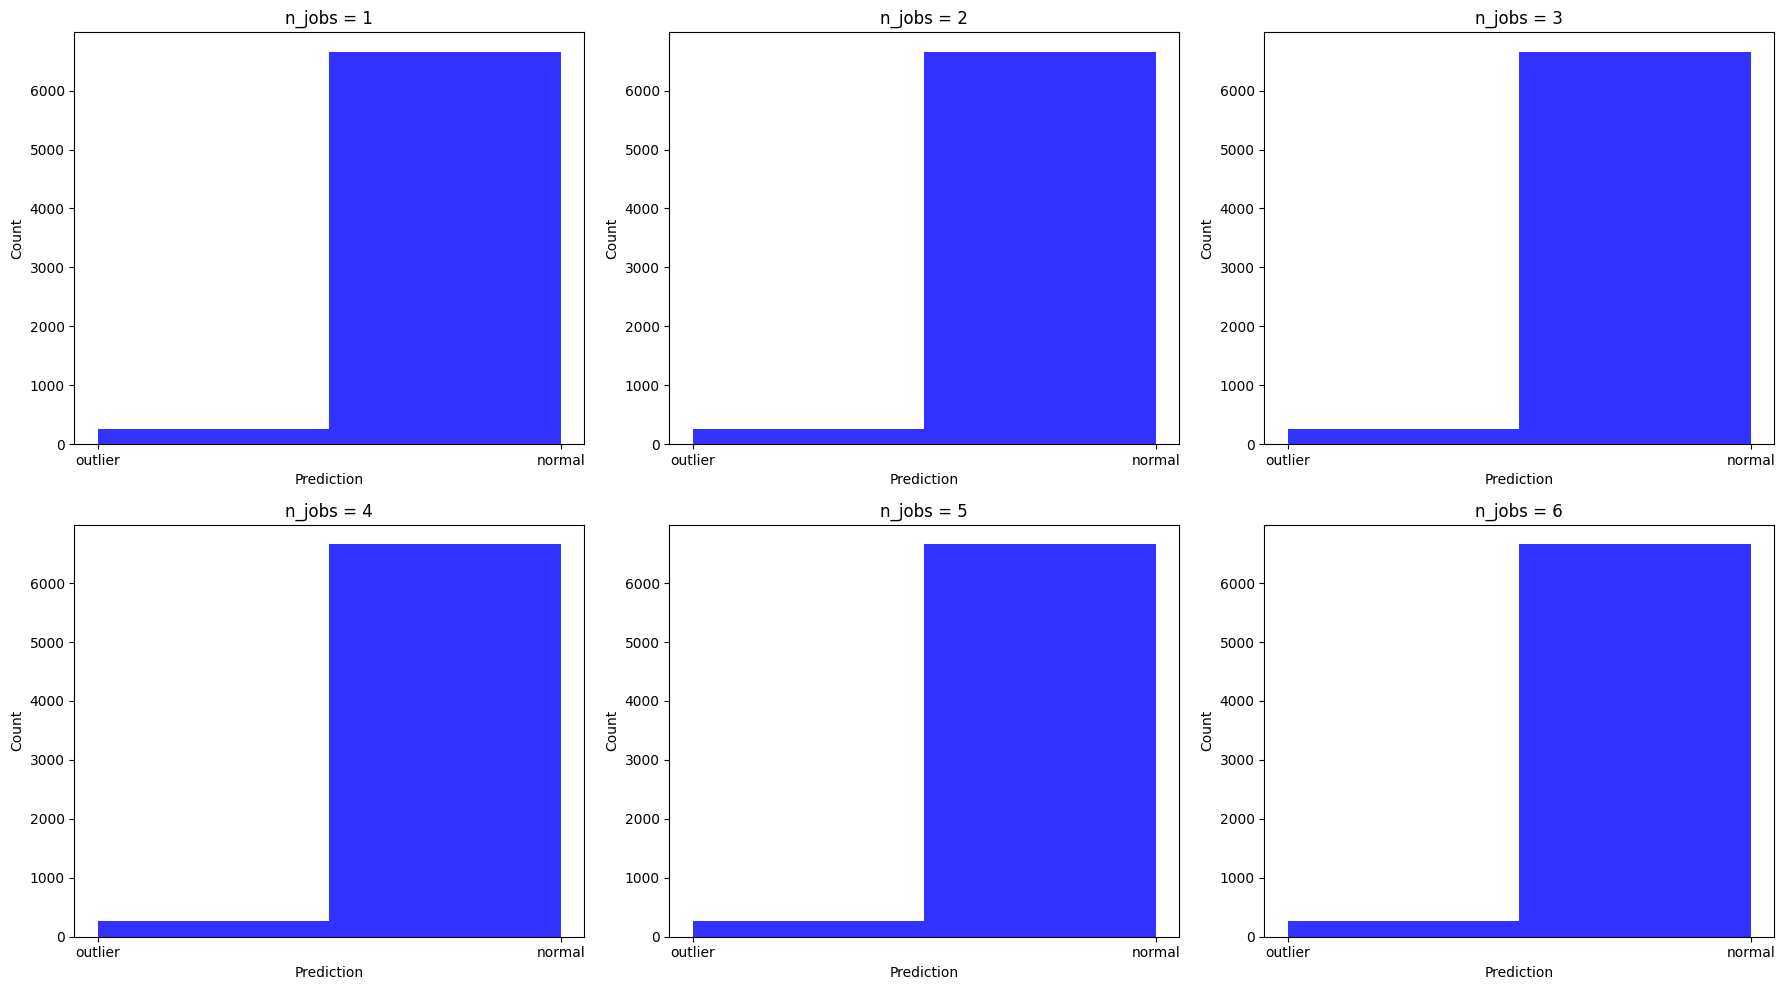

In [101]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
n_jobs_values = range(1, 7)

for n_jobs, ax in zip(n_jobs_values, axs.flat):
    model = GridSearchCV(IsolationForest(n_jobs=n_jobs, random_state=5, contamination=outlier_fraction), params, scoring='homogeneity_score', cv=5)
    model.fit(X, Y)
    scores_prediction = model.decision_function(X)
    y1_pred = model.predict(X)
    predictions = ['normal' if pred == 1 else 'outlier' for pred in y1_pred]
    print("n_jobs =", n_jobs, "Количество выбросов:", predictions.count('outlier'))

    ax.hist(predictions, bins=2, color = 'b', alpha=0.8)
    ax.set_title("n_jobs = " + str(n_jobs))
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


--------------------------------------

### Задание 3. Визуализация ROC-кривой в зависимости от параметров Isolation Forest (3 балла)
Для каждого Isolation Forest создайте отдельную roc_curve и полотно с шестью графиками для визуализации шести ROC-кривых в зависимости от параметра n_jobs.

В название каждого графика выведите F1-score, Precision и Recall для каждой модели Isolation Forest.



In [102]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score

params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 10))}
gscv = GridSearchCV(IsolationForest(n_jobs=4, random_state=5, contamination=outlier_fraction), params, scoring='homogeneity_score', cv=5)
gscv.fit(X, Y)
scores_prediction = gscv.decision_function(X)
y1_pred = gscv.predict(X)
y1_pred[y1_pred == 1] = 0
y1_pred[y1_pred == -1] = 1
f1 = f1_score(Y, y1_pred)
precision = precision_score(Y, y1_pred)
recall = recall_score(Y, y1_pred)


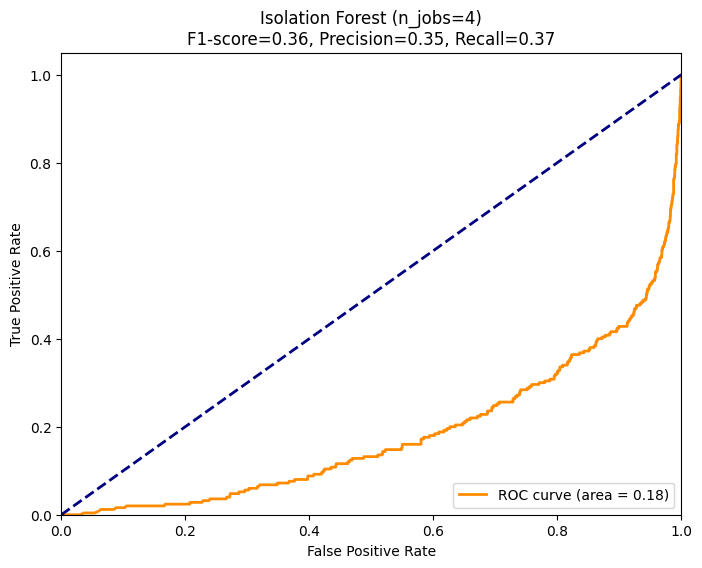

In [103]:
fpr, tpr, thresholds = roc_curve(Y, scores_prediction)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Isolation Forest (n_jobs=4)\nF1-score={f1:.2f}, Precision={precision:.2f}, Recall={recall:.2f}")
plt.legend(loc="lower right")
plt.show()

----------------------------------------


### Задание 4. Проверка эффективности моделей без учителя (4 балла)
Ранее мы обсуждали, что методы обучения с учителем можно использовать не только для поиска аномалий, но и для классической классификации. Аналогично первому заданию, используя разные алгоритмы обучения с учителем, постройте модель для классификации по данным датасета.

Наш третий датасет — данные по принятым и не принятым в университет студентам в зависимости от их среднего балла и балла за экзамен. В качестве переменных для анализа используйте средний балл (cgpa) и балл за экзамен (placement_exam_marks), а в качестве зависимой переменной в кластеризации используйте переменную placed.

Создайте поле из шести графиков. Каждый график должен представлять собой confusion_matrix (heatmap или тепловую карту) с попаданиями модели (матрица 2 на 2 с попаданиями модели, как делали на третьей неделе). Каждый график должен иметь заголовок и названия полей. На тепловой карте на каждом квадратике должно быть указано число, а также colorbar с правой стороны.

Поместите на графики следующие 6 алгоритмов:

- k-Nearest Neighbors (KNN).
- SVM (Support Vector Machine).
- Random Forest.
- AdaBoost.
- Gradient Boosting.
- Decision Tree.


In [104]:
placement = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_04_visualization/data/placement.csv')
placement.head()

,cgpa,placement_exam_marks,placed
0,7.19,26.0,1
1,7.46,38.0,1
2,7.54,40.0,1
3,6.42,8.0,1
4,7.23,17.0,0


In [105]:
placement.isnull().sum()

cgpa                    0
placement_exam_marks    0
placed                  0
dtype: int64

In [106]:
placement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cgpa                  1000 non-null   float64
 1   placement_exam_marks  1000 non-null   float64
 2   placed                1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [107]:
placement.describe()

,cgpa,placement_exam_marks,placed
count,1000.000000,1000.000000,1000.000000
mean,6.961240,32.225000,0.489000
std,0.615898,19.130822,0.500129
min,4.890000,0.000000,0.000000
25%,6.550000,17.000000,0.000000
50%,6.960000,28.000000,0.000000
75%,7.370000,44.000000,1.000000
max,9.120000,100.000000,1.000000


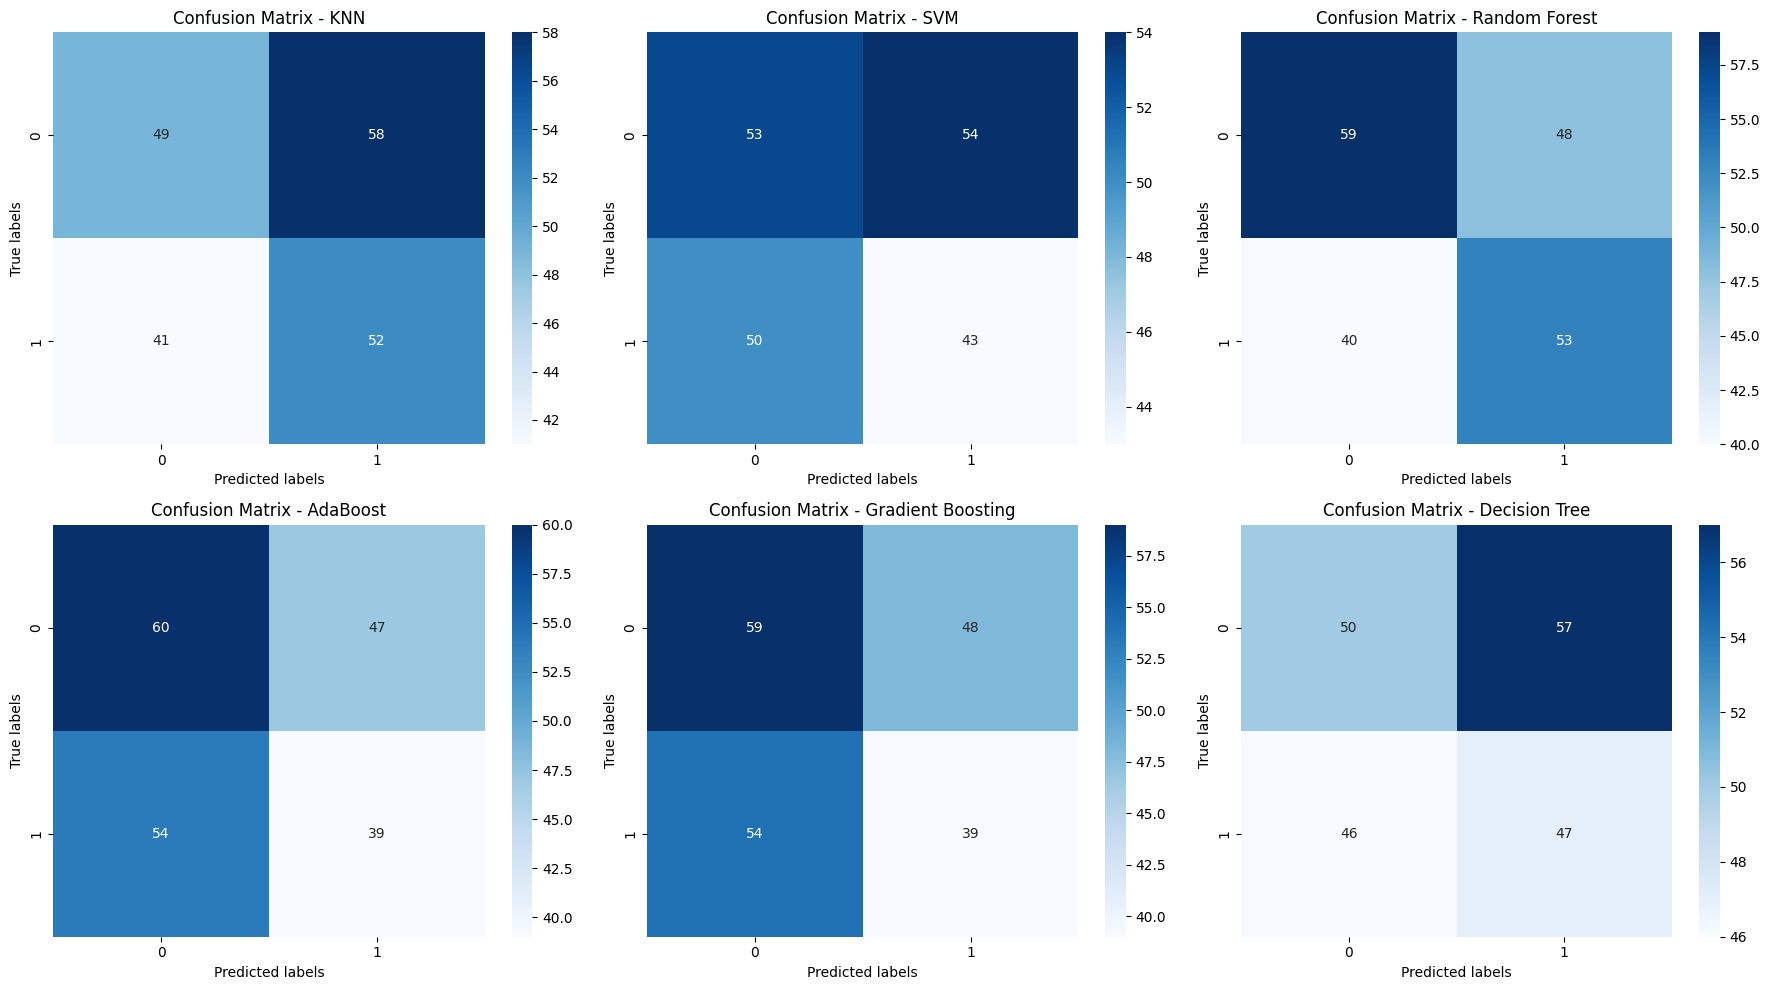

In [108]:
from sklearn.svm import SVC

X = placement[['cgpa', 'placement_exam_marks']]
y = placement['placed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for (name, model), ax in zip(models.items(), axs.flat):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

plt.tight_layout()
plt.show()